In [106]:
import json
import os

import dotenv
import numpy as np


dotenv.load_dotenv(override=True)

DATA = os.getenv("DATA")
if not DATA:
    raise Exception('Not able to find "DATA" environment variable')

In [3]:
DATA

'/Users/tobias/Downloads/anno/mtsd_v2_fully_annotated/annotations'

In [67]:
anno_files = os.listdir(DATA)
len(anno_files)

41909

In [8]:
with open("data/classes/classes.json") as f:
    classes = json.load(f)
len(classes)

402

In [20]:
with open('data/classes/delete.txt') as f:
    delete = f.readlines()
delete = [s.replace('\n', '') for s in delete]
delete = [s for s in delete if s != '']
len(delete)

145

In [68]:
new_anno_dir = os.path.join(os.path.dirname(DATA), 'anno_2')
os.makedirs(new_anno_dir, exist_ok=True)

In [69]:
n_pano = 0
n_in_delete = 0

for anno_file in anno_files:
    with open(os.path.join(DATA, anno_file)) as f:
        anno = json.load(f)
    
    if anno['ispano']:
        n_pano += 1
        continue
    
    anno_new = {
        'labels': [],
        'boxes': [],
        'areas': [],
        }
    keep_anno = True

    for obj in anno['objects']:
        if obj['label'] in delete:
            n_in_delete += 1
            keep_anno = False
            break

        anno_new['labels'].append(obj['label'])
        box = obj['bbox']
        anno_new['boxes'].append([box['xmin'], box['ymin'], box['xmax'], box['ymax']])
        anno_new['areas'].append((box['xmax'] - box['xmin']) * (box['ymax'] - box['ymin']))

    if keep_anno:
        filename = os.path.join(new_anno_dir, anno_file)
        with open(filename, "w+") as f:
            json.dump(anno_new, f, indent=6)

n_pano, n_in_delete

(941, 11679)

In [70]:
anno_files = os.listdir(new_anno_dir)
len(anno_files)

29290

In [75]:
err = []

for anno_file in anno_files:
    try:
        with open(os.path.join(new_anno_dir, anno_file)) as f:
            anno = json.load(f)
        if len(anno['labels']) == 0:
            err += [anno_file]
    except Exception as e:
        print(anno_file)

In [72]:
os.remove(os.path.join(new_anno_dir, '.DS_Store'))

In [73]:
anno_files = os.listdir(new_anno_dir)
len(anno_files)

29289

In [76]:
len(err)

128

In [77]:
with open('data/classes/keep.txt') as f:
    keep = f.readlines()
keep = [s.replace('\n', '') for s in keep]
keep = [item for s in keep if s != '' for item in s.split(', ')]
len(keep)

43

In [86]:
count = {}
areas = []
areas_other = []

for anno_file in anno_files:
    with open(os.path.join(new_anno_dir, anno_file)) as f:
        anno = json.load(f)

    for label, area in zip(anno['labels'], anno['areas']):
        if label in keep:
            areas.append(area)
            if label in count:
                count[label] += 1
            else:
                count[label] = 1
        else:
            areas_other.append(area)

len(areas), len(areas_other)

(15530, 123787)

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

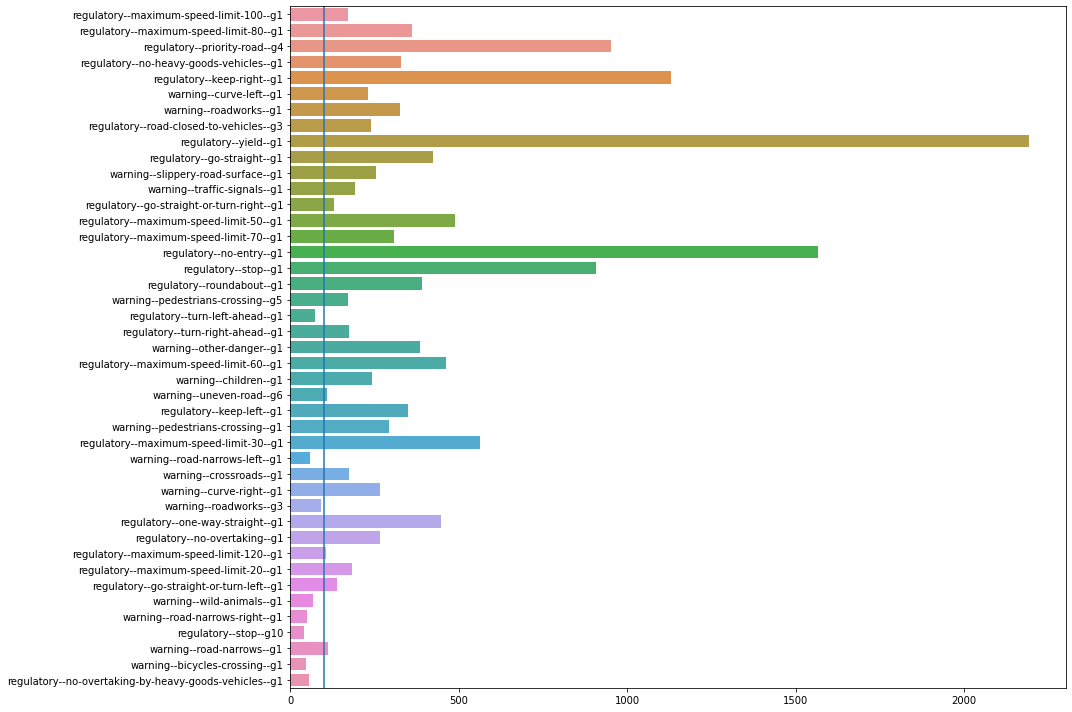

In [99]:
fig = plt.figure(figsize=(15,10))
y = list(count.keys())
x = list(count.values())
sns.barplot(x=x, y=y)
plt.axvline(100, 0, 1)
plt.tight_layout()
plt.show()

In [118]:
np.array(list(count.items()))[np.array(list(count.values())) < 100]

array([['regulatory--turn-left-ahead--g1', '73'],
       ['warning--road-narrows-left--g1', '58'],
       ['warning--roadworks--g3', '92'],
       ['warning--wild-animals--g1', '69'],
       ['warning--road-narrows-right--g1', '50'],
       ['regulatory--stop--g10', '42'],
       ['warning--bicycles-crossing--g1', '46'],
       ['regulatory--no-overtaking-by-heavy-goods-vehicles--g1', '57']],
      dtype='<U53')

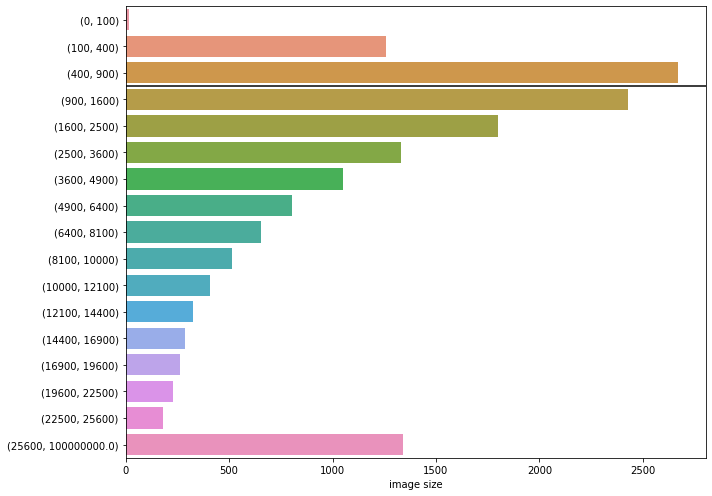

In [192]:
bins = list(range(10, 161, 10))
bins = {((bin-10)**2, bin**2):2 for bin in bins}
bins[(160**2, 1e8)] = 0
for c in areas:
    for bin in bins:
        if c > bin[0] and c < bin[1]:
            bins[bin] += 1
fig = plt.figure(figsize=(10,7))
sns.barplot(y=[str(key) for key in bins.keys()], x=list(bins.values()))
plt.axhline(2.5, 0, 2700, color='black')
plt.xlabel('image size')
plt.tight_layout()
plt.show()

In [182]:
sum(list(bins.values())[:3]), sum(list(bins.values())[3:])

(3945, 11617)

In [185]:
with open('data/classes/might_keep.txt') as f:
    might_keep = f.readlines()
might_keep = [s.replace('\n', '') for s in might_keep]
might_keep = [item for s in might_keep if s != '' for item in s.split(', ')]
len(might_keep)

87

In [187]:
might_count = {}
might_areas = []
might_areas_other = []

for anno_file in anno_files:
    with open(os.path.join(new_anno_dir, anno_file)) as f:
        anno = json.load(f)

    for label, area in zip(anno['labels'], anno['areas']):
        if label in might_keep:
            might_areas.append(area)
            if label in might_count:
                might_count[label] += 1
            else:
                might_count[label] = 1
        else:
            might_areas_other.append(area)

len(might_areas), len(might_areas_other)

(14606, 124711)

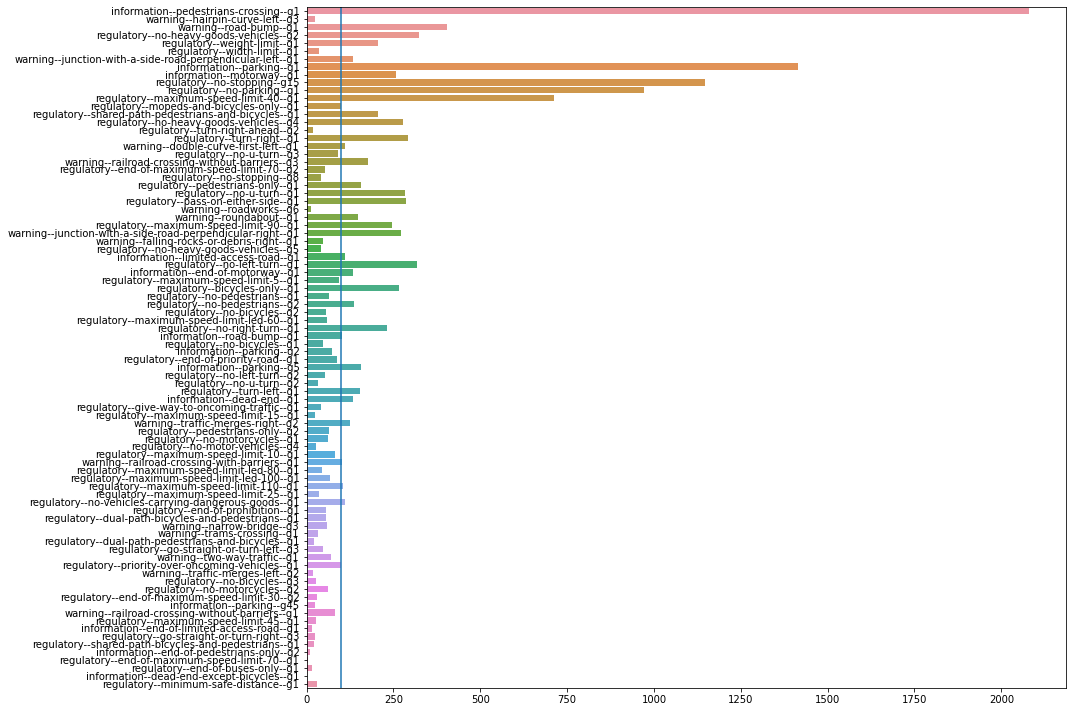

In [188]:
fig = plt.figure(figsize=(15,10))
y = list(might_count.keys())
x = list(might_count.values())
sns.barplot(x=x, y=y)
plt.axvline(100, 0, 1)
plt.tight_layout()
plt.show()

In [190]:
len(np.array(list(might_count.items()))[np.array(list(might_count.values())) < 100])

50

In [191]:
np.array(list(might_count.items()))[np.array(list(might_count.values())) < 100][:10]

array([['warning--hairpin-curve-left--g3', '25'],
       ['regulatory--width-limit--g1', '37'],
       ['regulatory--mopeds-and-bicycles-only--g1', '99'],
       ['regulatory--turn-right-ahead--g2', '18'],
       ['regulatory--no-u-turn--g3', '91'],
       ['regulatory--end-of-maximum-speed-limit-70--g2', '53'],
       ['regulatory--no-stopping--g8', '41'],
       ['warning--roadworks--g6', '14'],
       ['warning--falling-rocks-or-debris-right--g1', '46'],
       ['regulatory--no-heavy-goods-vehicles--g5', '42']], dtype='<U58')

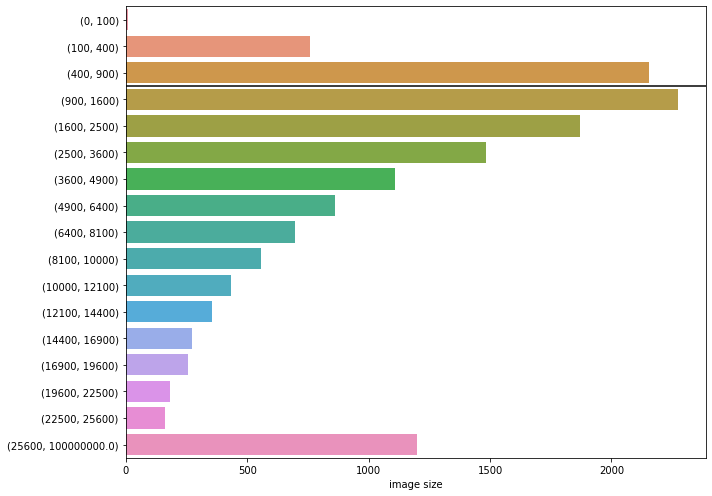

In [194]:
bins = list(range(10, 161, 10))
bins = {((bin-10)**2, bin**2):2 for bin in bins}
bins[(160**2, 1e8)] = 0
for c in might_areas:
    for bin in bins:
        if c > bin[0] and c < bin[1]:
            bins[bin] += 1
fig = plt.figure(figsize=(10,7))
sns.barplot(y=[str(key) for key in bins.keys()], x=list(bins.values()))
plt.axhline(2.5, 0, 2700, color='black')
plt.xlabel('image size')
plt.tight_layout()
plt.show()

In [195]:
sum(list(bins.values())[:3]), sum(list(bins.values())[3:])

(2920, 11716)

## Speed limits

In [199]:
[(c,might_count[c]) for c in might_count if "regulatory--maximum-speed-limit" in c]

[('regulatory--maximum-speed-limit-40--g1', 711),
 ('regulatory--maximum-speed-limit-90--g1', 247),
 ('regulatory--maximum-speed-limit-5--g1', 93),
 ('regulatory--maximum-speed-limit-led-60--g1', 60),
 ('regulatory--maximum-speed-limit-15--g1', 25),
 ('regulatory--maximum-speed-limit-10--g1', 83),
 ('regulatory--maximum-speed-limit-led-80--g1', 45),
 ('regulatory--maximum-speed-limit-led-100--g1', 67),
 ('regulatory--maximum-speed-limit-110--g1', 105),
 ('regulatory--maximum-speed-limit-25--g1', 35),
 ('regulatory--maximum-speed-limit-45--g1', 27)]